In [2]:
import pandas as pd
sales_data=pd.read_csv(r"C:\Users\Elakkiya\Downloads\dominos\Pizza_Sale - pizza_sales_pre_processed_1.csv")

In [4]:
ingredients_data=pd.read_csv(r"C:\Users\Elakkiya\Downloads\dominos\Pizza_ingredients - Pizza_ingredients_cleaned.csv")

In [8]:
import pandas as pd

# Load the sales data
sales_data = pd.read_csv(r"C:\Users\Elakkiya\Downloads\dominos\Pizza_Sale - pizza_sales_pre_processed_1.csv")

# Ensure order_date column is in datetime format
sales_data['order_date'] = pd.to_datetime(sales_data['order_date'])

# Create a 'week' column based on the order_date
sales_data['week'] = sales_data['order_date'].dt.isocalendar().week

# Filter for week 7
week_7_sales = sales_data[sales_data['week'] == 7]

# Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# List all grouped pizza names and their total quantities
print("Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")


Pizzas sold in week 7:
The Barbecue Chicken Pizza: 48 pizzas
The Big Meat Pizza: 33 pizzas
The Brie Carre Pizza: 12 pizzas
The Calabrese Pizza: 18 pizzas
The California Chicken Pizza: 45 pizzas
The Chicken Alfredo Pizza: 19 pizzas
The Chicken Pesto Pizza: 19 pizzas
The Classic Deluxe Pizza: 39 pizzas
The Five Cheese Pizza: 30 pizzas
The Four Cheese Pizza: 45 pizzas
The Greek Pizza: 31 pizzas
The Green Garden Pizza: 26 pizzas
The Hawaiian Pizza: 41 pizzas
The Italian Capocollo Pizza: 27 pizzas
The Italian Supreme Pizza: 36 pizzas
The Italian Vegetables Pizza: 28 pizzas
The Mediterranean Pizza: 11 pizzas
The Mexicana Pizza: 33 pizzas
The Napolitana Pizza: 28 pizzas
The Pepper Salami Pizza: 15 pizzas
The Pepperoni Pizza: 53 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 22 pizzas
The Prosciutto and Arugula Pizza: 29 pizzas
The Sicilian Pizza: 48 pizzas
The Soppressata Pizza: 19 pizzas
The Southwest Chicken Pizza: 39 pizzas
The Spicy Italian Pizza: 33 pizzas
The Spinach Pesto Pizza: 15

11:26:18 - cmdstanpy - INFO - Chain [1] start processing
11:26:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model MAPE: 20.39%


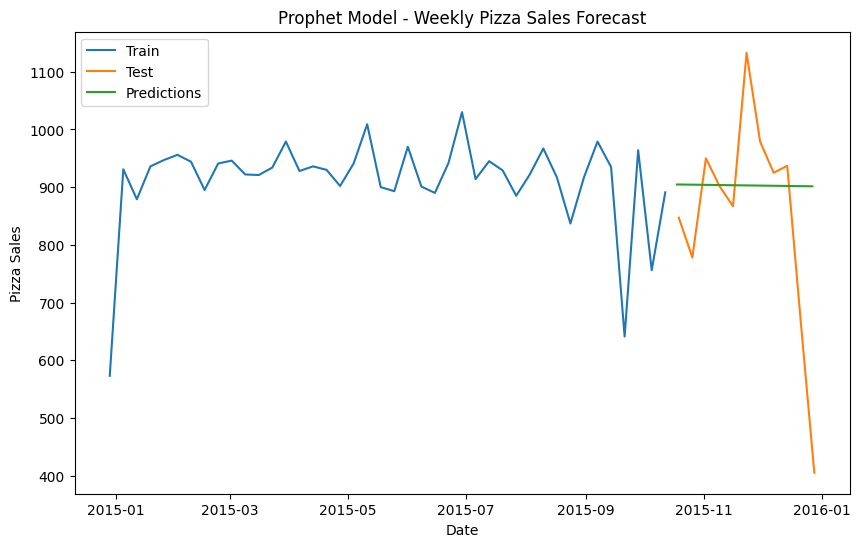

In [12]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the sales data
sales_data = pd.read_csv(r"C:\Users\Elakkiya\Downloads\dominos\Pizza_Sale - pizza_sales_pre_processed_1.csv")
sales_data['order_date'] = pd.to_datetime(sales_data['order_date'])

# Aggregate pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(sales_data)

# Split data into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Train the Prophet model
prophet_model = Prophet()
prophet_model.fit(train)

# Make predictions for the test set
future = prophet_model.make_future_dataframe(periods=len(test), freq='W')
forecast = prophet_model.predict(future)

# Extract the forecasted values for the test period
predictions = forecast[['ds', 'yhat']].tail(len(test)).set_index('ds')

# Define MAPE function
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

# Evaluate the model
actual = test.set_index('ds')['y']
predicted = predictions['yhat']
prophet_mape_score = mape(actual, predicted)

print(f"Prophet Model MAPE: {prophet_mape_score:.2f}%")

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(predictions.index, predictions['yhat'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Pizza Sales')
plt.title('Prophet Model - Weekly Pizza Sales Forecast')
plt.legend()
plt.show()


In [8]:
pd.set_option("display.max_rows", None)

In [5]:
import pandas as pd
from prophet import Prophet
import warnings
import logging

# Suppress warnings
warnings.filterwarnings("ignore")

# Suppress cmdstanpy logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Load the pizza sales data
pizza_sales = pd.read_csv(r"C:\Users\Elakkiya\Downloads\dominos\Pizza_Sale - pizza_sales_pre_processed_1.csv")

# Step 1: Data Preparation - Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.rename(columns={'week': 'ds', 'quantity': 'y'}, inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Step 2: Create a function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=7):
    # Initialize the Prophet model
    model = Prophet()
    model.fit(train)
    
    # Create a dataframe for future predictions
    future = model.make_future_dataframe(periods=periods, freq='D')
    
    # Forecast
    forecast = model.predict(future)
    
    # Extract the forecast for the specified period
    forecasted_values = forecast[['ds', 'yhat']].tail(periods)['yhat'].tolist()
    
    return pizza_type, forecasted_values

# Step 3: Forecast for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, start_date, periods=7):
    # Dictionary to store the forecasted sales for each pizza type
    pizza_type_forecasts = {}

    # Calculate total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['y'].sum()

    # Set the next week's date range (hardcoded for 23.09.2024 to 29.09.2024)
    next_week_start = pd.to_datetime(start_date)  # Use the provided start date
    next_week_end = next_week_start + pd.Timedelta(days=periods-1)

    # Loop through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        # Filter the data for this pizza type
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        # Prepare the data for Prophet
        train = pizza_type_data[['ds', 'y']]

        # Forecast sales for the next week for this pizza type
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        # Store the forecast in the dictionary
        if forecast:
            pizza_type_forecasts[pizza_type] = forecast  # The forecast is already a list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Step 4: Forecast pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, '2024-09-23', periods=7)

# Display the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0  # To accumulate the forecasted quantities

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast_quantity = int(sum(forecast))  # Sum the forecasted values for the week
    next_week_pizza_sales_forecasts[pizza_type] = forecast_quantity
    print(f'{pizza_type}: {forecast_quantity} pizzas')
    total_forecasted_quantity += forecast_quantity

# Display the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

# Step 5: Load the ingredients data
ingredients = pd.read_csv(r"C:\Users\Elakkiya\Downloads\dominos\Pizza_ingredients - Pizza_ingredients_cleaned.csv")

# Copy ingredients, map predicted sales, and calculate total ingredient quantity
ingredients_predicted = ingredients.copy()

# Assuming each pizza requires certain quantities of ingredients
# 'pizza_name_id' should exist in the ingredients DataFrame to map quantities
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum up the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()

# Print the results for predicted ingredients
print("Total quantity of predicted ingredients for the following week:")
for ingredient, total_qty in ingredient_totals.items():
    print(f'{ingredient}: {total_qty} grams')

# Display the updated DataFrame
print(ingredients_predicted)


Forecasted sales for the week 2024-09-23 to 2024-09-29:
bbq_ckn_l: 112 pizzas
bbq_ckn_m: 102 pizzas
bbq_ckn_s: 58 pizzas
big_meat_s: 216 pizzas
brie_carre_s: 60 pizzas
calabrese_m: 70 pizzas
calabrese_s: 13 pizzas
cali_ckn_l: 114 pizzas
cali_ckn_m: 105 pizzas
cali_ckn_s: 66 pizzas
ckn_alfredo_l: 25 pizzas
ckn_alfredo_m: 87 pizzas
ckn_alfredo_s: 17 pizzas
ckn_pesto_l: 45 pizzas
ckn_pesto_m: 41 pizzas
ckn_pesto_s: 36 pizzas
classic_dlx_l: 62 pizzas
classic_dlx_m: 157 pizzas
classic_dlx_s: 99 pizzas
five_cheese_l: 146 pizzas
four_cheese_l: 158 pizzas
four_cheese_m: 67 pizzas
green_garden_l: 11 pizzas
green_garden_m: 34 pizzas
green_garden_s: 72 pizzas
hawaiian_l: 114 pizzas
hawaiian_m: 61 pizzas
hawaiian_s: 129 pizzas
ital_cpcllo_l: 91 pizzas
ital_cpcllo_m: 43 pizzas
ital_cpcllo_s: 35 pizzas
ital_supr_l: 95 pizzas
ital_supr_m: 104 pizzas
ital_supr_s: 24 pizzas
ital_veggie_l: 21 pizzas
ital_veggie_m: 56 pizzas
ital_veggie_s: 34 pizzas
mediterraneo_l: 46 pizzas
mediterraneo_m: 39 pizzas
med

In [7]:
ingredients_predicted

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecue Chicken,40,112.0,4480.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15,112.0,1680.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20,112.0,2240.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30,112.0,3360.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60,112.0,6720.0
5,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecue Sauce,15,112.0,1680.0
6,bbq_ckn_m,The Barbecue Chicken Pizza,Barbecue Chicken,30,102.0,3060.0
7,bbq_ckn_m,The Barbecue Chicken Pizza,Red Peppers,10,102.0,1020.0
8,bbq_ckn_m,The Barbecue Chicken Pizza,Green Peppers,15,102.0,1530.0
9,bbq_ckn_m,The Barbecue Chicken Pizza,Tomatoes,20,102.0,2040.0
